# 04 Riluzole Relationships Between FDG and Plasma Biomarkers
update that saves all params and pvalues, including for covariates and not just for the  biomarker   
switching x and y so plasma is always x   
changing models to include covariates only if significant in that individual model   


In [1]:
# install required packages - commented out so it doesn't install every time
#%conda install -n Lauren openpyxl numpy pandas statsmodels plotnine matplotlib scikit-learn scipy mizani nbconvert pandoc pyreadstat kmodes seaborn

# import required packages
import numpy as np;
import pandas as pd;
from sklearn import preprocessing 
import statsmodels as sm;
import statsmodels.formula.api as smf;
import plotnine as p9;
import itertools
import pickle

import scipy; # for spearmann correlation



C:\Users\Lauren.Koenig\AppData\Roaming\Python\Python39\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


# read in and clean data

In [2]:
data_folder_loc = '//admsyn/Primary/ADM/CustomerStudies/Rockefeller/Riluzole_Biomarkers/'
code_folder_loc = '//admsyn/homes/@DH-ADMDX/0/lauren.koenig-1606/code/Riluzole FDG/'

In [3]:
# read in data
composite_rr, pons_rr, para_rr, new_para_rr, ras_rr = pd.read_pickle(code_folder_loc + '/output/01_newdata.pkl')

In [4]:
all_data = new_para_rr #[~new_para_rr['ID_ADM'].isin(['APE-792_23', 'APE-792_35', 'APE-792_39', 'APE-792_65', 'APE-792_71', 'RIL_17', 'RIL_21', 'RIL_24', 'APE-792_9','APE-792_22', 'RIL_13'])].copy()#
data_name = 'new_para_rr'

In [5]:
# orig has additional 
# 
# pons (1st) is missing 'L_Hip', 'R_Hip', 'Avg_Hip', 'Temp', 'FRONTAL-gm', 'Avg_MedOrbFrontal', 'Avg PCC'
# para (1st) is missing 'L_Hip', 'R_Hip', 'Avg_Hip', 'Temp', 'FRONTAL-gm', 'Avg_MedOrbFrontal'

# para (new) is missing 'L_Hip', 'R_Hip', 'Avg_Hip', 'Temp', 'Avg PCC', 'Avg_MedOrbFrontal'
# para (new) also has 'SensMot-gm', 'Paracentral-gm', 'RASref1-gm'

# ras (new) is missing 'L_Hip', 'R_Hip', 'Avg_Hip', 'Temp', 'Avg_MedOrbFrontal'
# ras (new) also has 'SensMot-gm', 'Paracentral-gm', 'RASref1-gm', 'CO', 'Graycer-gm', 'Vermis-gm'

In [6]:
# define biomarker groups
FDG_columns = ['Avg_MedOrbFrontal', 'Graycer_gm', 'Avg_PCC', 'Avg_Hip', 'MTL_gm', 'CO', 'Temp', 'SensMot_gm', 'L_Hip',
 'Vermis_gm', 'FRONTAL_gm', 'AC_gm', 'Precun_gm', 'Par_gm', 'RASref1_gm', 'Temp_gm', 'Paracentral_gm', 'R_Hip', 'PostCing_gm']

plasma_columns = [ 'Ab40', 'Ab42', 'Ab42_40', 'GFAP','NFL',  'pTau181', 'pTau217',  'pTau231', 'pTau181_Ab42']
log10_plasma_columns = [s + '_log10' for s in plasma_columns]

cog_columns = ['MMSE', 'adascogtotal', 'bvrt', 'dstotal','tma','tmb',  'cowattotal', 'cdrtotal', 'cdrsum', 'adltotal', 'npitotal', 'gds']
vol_columns = ['VOL_Ventricles_Lz',
       'VOL_Ventricles_Rz', 'VOL_Putamen_Lz', 'VOL_Putamen_Rz',
       'VOL_ParaHip_Lz', 'VOL_ParaHip_Rz', 'VOL_Fusi_Lz', 'VOL_Fusi_Rz',
       'VOL_InfTemp_Lz', 'VOL_InfTemp_Rz', 'VOL_MidTemp_Lz', 'VOL_MidTemp_Rz',
       'VOL_SupTemp_Lz', 'VOL_SupTemp_Rz', 'VOL_Precun_Lz', 'VOL_Precun_Rz',
       'VOL_InfPar_Lz', 'VOL_InfPar_Rz', 'VOL_ParaPostCentr_Lz',
       'VOL_ParaPostCentr_Rz', 'VOL_SupraMarg_Lz', 'VOL_SupraMarg_Rz',
       'VOL_SupPar_Lz', 'VOL_SupPar_Rz', 'VOL_OrbitFront_Lz',
       'VOL_OrbitFront_Rz', 'VOL_Insula_Lz', 'VOL_Insula_Rz',
       'VOL_InfFront_Lz', 'VOL_InfFront_Rz', 'VOL_MidFront_Lz',
       'VOL_MidFront_Rz', 'VOL_SupFront_Lz', 'VOL_SupFront_Rz',
       'VOL_PrecFront_Lz', 'VOL_PrecFront_Rz', 'VOL_LatOcc_Lz',
       'VOL_LatOcc_Rz', 'VOL_Lingual_Lz', 'VOL_Lingual_Rz', 'VOL_Cuneus_Lz',
       'VOL_Cuneus_Rz', 'VOL_Pericalc_Lz', 'VOL_Pericalc_Rz',
       'VOL_AntCingulate_Lz', 'VOL_AntCingulate_Rz', 'VOL_PostCingulate_Lz',
       'VOL_PostCingulate_Rz', 'VOL_Entorhinal_Lz', 'VOL_Entorhinal_Rz',
       'VOL_Hip_Lz', 'VOL_Hip_Rz', 'VOL_TotalGrayz', 'VOL_TotalGray_Lz',
       'VOL_TotalGray_Rz', 'VOL_LatTemp_Lz', 'VOL_LatTemp_Rz',
       'VOL_Parietal_Lz', 'VOL_Parietal_Rz', 'VOL_Frontal_Lz',
       'VOL_Frontal_Rz', 'VOL_InfMidTemp_Lz', 'VOL_InfMidTemp_Rz',
       'VOL_InfInsFrontal_Lz', 'VOL_InfInsFrontal_Rz', 'VOL_MidSupFrontal_Lz',
       'VOL_MidSupFrontal_Rz', 'VOL_Inf_Mid_Fus_Temp_Lz',
       'VOL_Inf_Mid_Fus_Temp_Rz', 'VOL_Precun_InfPar_Lz',
       'VOL_Precun_InfPar_Rz', 'VOL_Precun_InfPar_Supramarg_Lz',
       'VOL_Precun_InfPar_Supramarg_Rz', 'VOL_LatOccLingCun_Lz',
       'VOL_LatOccLingCun_Rz', 'VOL_InfParSupra_Lz', 'VOL_InfParSupra_Rz']

In [7]:
all_data['VOL_Front_Lz'] = all_data[['VOL_InfFront_Lz', 'VOL_MidFront_Lz', 'VOL_SupFront_Lz']].mean(axis = 1)
all_data['VOL_Front_Rz'] = all_data[['VOL_InfFront_Rz', 'VOL_MidFront_Rz', 'VOL_SupFront_Rz']].mean(axis = 1)

all_data['VOL_Temp_Lz'] = all_data[['VOL_InfTemp_Lz', 'VOL_MidTemp_Lz', 'VOL_SupTemp_Lz']].mean(axis = 1)
all_data['VOL_Temp_Rz'] = all_data[['VOL_InfTemp_Rz', 'VOL_MidTemp_Rz', 'VOL_SupTemp_Rz']].mean(axis = 1)


In [8]:
# define biomarker groups
FDG_columns2 = [
 'Avg_MedOrbFrontal','Avg_MedOrbFrontal',
  'Avg_PCC','Avg_PCC', 
  'Avg_Hip',  'Avg_Hip',
  'FRONTAL_gm', 'FRONTAL_gm', 
  'AC_gm',  'AC_gm', 
  'Precun_gm', 'Precun_gm',
  'Par_gm', 'Par_gm', 
  'Temp_gm','Temp_gm', 
  'PostCing_gm','PostCing_gm']

vol_columns2 = [
    'VOL_OrbitFront_Lz','VOL_OrbitFront_Rz',
    'VOL_ParaPostCentr_Lz','VOL_ParaPostCentr_Rz',
    'VOL_Hip_Lz', 'VOL_Hip_Rz',
    'VOL_Front_Lz', 'VOL_Front_Rz', 
    'VOL_AntCingulate_Lz', 'VOL_AntCingulate_Rz', 
    'VOL_Precun_Lz', 'VOL_Precun_Rz',
    'VOL_Parietal_Lz', 'VOL_Parietal_Rz',
    'VOL_Temp_Lz', 'VOL_Temp_Rz', 
    'VOL_PostCingulate_Lz',  'VOL_PostCingulate_Rz', 
]

In [9]:
[ele for ele in FDG_columns2 if ele in all_data.columns]

['FRONTAL_gm',
 'FRONTAL_gm',
 'AC_gm',
 'AC_gm',
 'Precun_gm',
 'Precun_gm',
 'Par_gm',
 'Par_gm',
 'Temp_gm',
 'Temp_gm',
 'PostCing_gm',
 'PostCing_gm']

In [10]:
print('any missing covariate data?')
all_data[all_data['timepoint'].isin(['base'])].dropna(subset = [ele for ele in FDG_columns if ele in all_data.columns], how = 'all')[['age', 'Education_years', 'sex', 'apoe4_carrier', 'race']].isna().value_counts().sort_index()

any missing covariate data?


age    Education_years  sex    apoe4_carrier  race 
False  False            False  False          False    40
                               True           False     1
                                              True      6
True   True             True   True           True      1
Name: count, dtype: int64

## make data subsets

In [11]:
# make data subsets
# baseline and non-trial data
baseline_data = all_data[all_data['timepoint'].isin(['base', 'not part of trial'])]

# baseline only
baseline_trial_data = all_data[all_data['timepoint'].isin(['base'])]

# baseline only and only age 70-80
baseline_trial_data_70_80 = baseline_trial_data[(baseline_trial_data['age']<=80) & (baseline_trial_data['age']>=70)]

# Analyses

## version using log10 plasma data

In [15]:
covariate_p_threshold = 0.05

In [16]:
biomarker_relationship_results_log10 = pd.DataFrame()


for varlist in [vol_columns2]:
    combinations = pd.DataFrame(zip(FDG_columns2, varlist))
    combinations = combinations[combinations[0].isin(all_data.columns) & combinations[1].isin(all_data.columns)].reset_index(drop = True)

    for idx in range(combinations[0].size):
        x_var = combinations[0][idx]
        y_var = combinations[1][idx]
        
        temp_df_baseline =  baseline_trial_data.copy().dropna(subset = [y_var, x_var])

        # z-score data
        temp_df_baseline[[y_var, x_var, 'Education_years', 'age']] = preprocessing.StandardScaler().fit_transform(temp_df_baseline[[y_var, x_var, 'Education_years', 'age']])

        # run 1 - check for significant covariates
        sig_pvals_start = ['age', 'Education_years', 'apoe4_carrier', 'sex', 'race', x_var]
        change = 1
        full_model = smf.ols(formula = y_var + ' ~ ' + ' + '.join(sig_pvals_start), data = temp_df_baseline).fit()
        temp_df_baseline['full_model_residuals'] = full_model.resid

        while change > 0:
            model_vars = ' + '.join(sig_pvals_start)        
            test_model = smf.ols(formula = y_var + ' ~ ' + model_vars, data = temp_df_baseline).fit()
            sig_pvals = test_model.pvalues[test_model.pvalues < covariate_p_threshold].index.to_list()
            sig_pvals = [ele.split('[')[0] for ele in sig_pvals] # drop the [] indicators
            sig_pvals_unique = []
            for item in sig_pvals:
                if (item not in sig_pvals_unique) & (item not in ['Intercept']): sig_pvals_unique.append(item)
            if (x_var not in sig_pvals_unique):
                sig_pvals_unique = sig_pvals_unique + [x_var]
            change = len(sig_pvals_start) - len(sig_pvals_unique)
            sig_pvals_start = sig_pvals_unique
        
        # run 2 -with just the significant covariates (but forcing the x_var to be included)
        model_vars = ' + '.join(sig_pvals_unique)        
        model = smf.ols(formula = y_var + ' ~ ' + model_vars , data = temp_df_baseline).fit()

        model_p_val_baseline = model.pvalues
        model_B_val_baseline = model.params
        model_n_baseline = len(temp_df_baseline.dropna(subset = sig_pvals_unique + [y_var]))


        # save results
        temp_results  =  pd.DataFrame([y_var, x_var, model_p_val_baseline, model_B_val_baseline, model_n_baseline]).T

        temp_results.columns = ['y_var', 'x_var', 
        'model_p_val_baseline', 'model_B_val_baseline', 'model_n_baseline']
        
        # separate out p and B values into separate columns
        df_mv_age_pvals = pd.DataFrame(temp_results['model_p_val_baseline'][0]).T
        df_mv_age_pvals.columns = 'model_p_val_' + df_mv_age_pvals.columns
        temp_results[df_mv_age_pvals.columns] = df_mv_age_pvals

        df_mv_age_bvals = pd.DataFrame(temp_results['model_B_val_baseline'][0]).T
        df_mv_age_bvals.columns = 'model_B_val_' + df_mv_age_bvals.columns
        temp_results[df_mv_age_bvals.columns] = df_mv_age_bvals                
        
        # remove self-correlations
        temp_results = temp_results[~(temp_results['y_var'] == temp_results['x_var'])]

        # rename so var2 is in the same column
        temp_results = temp_results.rename(columns = dict(zip(temp_results.columns, [ele.replace(x_var, 'x_var') for ele in temp_results.columns ])))

        # add to full list of results
        biomarker_relationship_results_log10 = pd.concat([biomarker_relationship_results_log10, temp_results])


In [17]:
selected_p_column = ['model_p_val_x_var']

In [18]:
# set multiple comparisons correction type
mc = 'fdr_bh' #options are bonferroni, sidak, holm-sidak, holm, simes-hochberg, hommel, fdr_bh, fdr_by, fdr_tsbh, fdr_tsbky

# apply multiple comparisons correction separately for each plasma biomarker
#for var in biomarker_relationship_results_log10['y_var'].drop_duplicates().to_list():
#    biomarker_relationship_results_log10.loc[biomarker_relationship_results_log10['y_var'].isin([y_var]), selected_p_column] = biomarker_relationship_results_log10.loc[biomarker_relationship_results_log10['y_var'].isin([y_var]), selected_p_column].apply(lambda x: sm.stats.multitest.multipletests(x.replace({np.nan:1}), method=mc)[1])

# save results

In [14]:
biomarker_relationship_results_log10

""


In [21]:
biomarker_relationship_results_log10['x_var'].sort_values().unique()

array(['AC_gm', 'FRONTAL_gm', 'Par_gm', 'PostCing_gm', 'Precun_gm',
       'Temp_gm'], dtype=object)

In [22]:
with pd.ExcelWriter(code_folder_loc + 'output/04c_model_results_log10_' + data_name + '.xlsx') as writer:
   
    # use to_excel function and specify the sheet_name and index 
    # to store the dataframe in specified sheet
    biomarker_relationship_results_log10.to_excel(writer, sheet_name='All', index=False)
    biomarker_relationship_results_log10.loc[(biomarker_relationship_results_log10[selected_p_column].min(axis = 1)<0.05), :].round(3).to_excel(writer, sheet_name='Significant', index=False)

# Plot Results
the notes listed and graphs plotted are for relationships with significant model_p_val_x_var

In [26]:
biomarker_relationship_results_log10 = biomarker_relationship_results_log10.reset_index(drop = True)

In [34]:
biomarker_relationship_results_log10

,y_var,x_var,model_p_val_baseline,model_B_val_baseline,model_n_baseline,model_p_val_Intercept,model_p_val_x_var,model_B_val_Intercept,model_B_val_x_var
0,VOL_Front_Lz,FRONTAL_gm,Intercept 1.000000 FRONTAL_gm 0.005821 ...,Intercept 3.122502e-17 FRONTAL_gm 4.184...,42,1.0,0.005821,3.122502e-17,0.418429
1,VOL_Front_Rz,FRONTAL_gm,Intercept 1.000000 FRONTAL_gm 0.021271 ...,Intercept 4.857226e-17 FRONTAL_gm 3.544...,42,1.0,0.021271,4.857226e-17,0.354452
2,VOL_AntCingulate_Lz,AC_gm,Intercept 1.000000 AC_gm 0.256906 dt...,Intercept 6.245005e-17 AC_gm 1.78922...,42,1.0,0.256906,6.245005e-17,0.178923
3,VOL_AntCingulate_Rz,AC_gm,Intercept 1.000000 AC_gm 0.017461 dt...,Intercept -2.168404e-17 AC_gm 3.65017...,42,1.0,0.017461,-2.168404e-17,0.365017
4,VOL_Precun_Lz,Precun_gm,Intercept 1.000000 Precun_gm 0.003073 dt...,Intercept 2.428613e-17 Precun_gm 4.46004...,42,1.0,0.003073,2.428613e-17,0.446005
5,VOL_Precun_Rz,Precun_gm,Intercept 1.000000 Precun_gm 0.001527 dt...,Intercept 6.071532e-18 Precun_gm 4.73803...,42,1.0,0.001527,6.071532e-18,0.473804
6,VOL_Parietal_Lz,Par_gm,Intercept 1.000000 Par_gm 0.000014 dt...,Intercept 7.546047e-17 Par_gm 6.15704...,42,1.0,0.000014,7.546047e-17,0.615705
7,VOL_Parietal_Rz,Par_gm,Intercept 1.000000 Par_gm 0.000062 dt...,Intercept -9.367507e-17 Par_gm 5.77390...,42,1.0,0.000062,-9.367507e-17,0.577391
8,VOL_Temp_Lz,Temp_gm,Intercept 1.000000 Temp_gm 0.170673 dt...,Intercept -1.543904e-16 Temp_gm 2.15412...,42,1.0,0.170673,-1.543904e-16,0.215412
9,VOL_Temp_Rz,Temp_gm,Intercept 1.00000 Temp_gm 0.00248 dtyp...,Intercept 4.076600e-17 Temp_gm 4.54774...,42,1.0,0.002480,4.076600e-17,0.454774


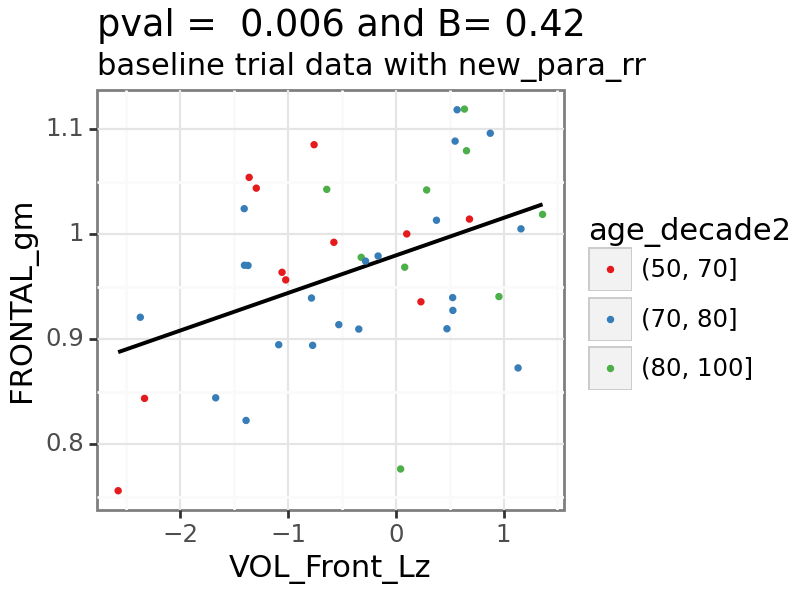

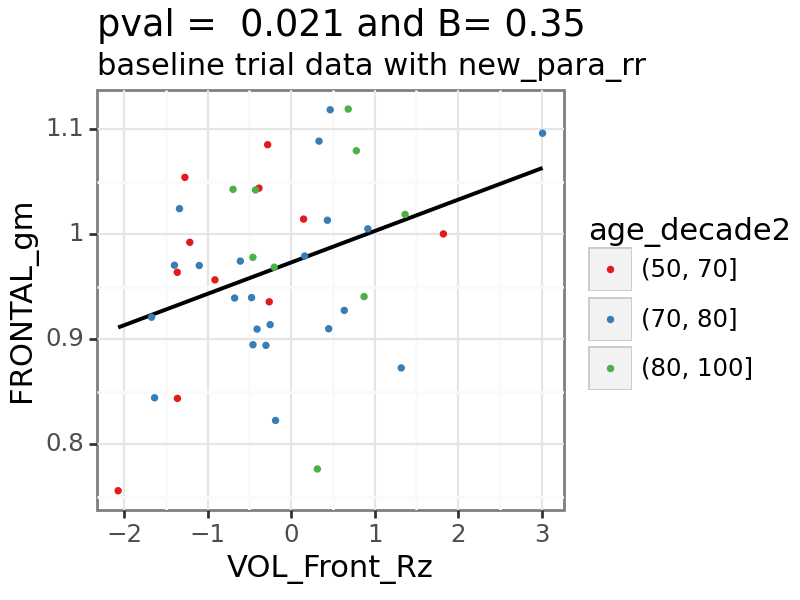

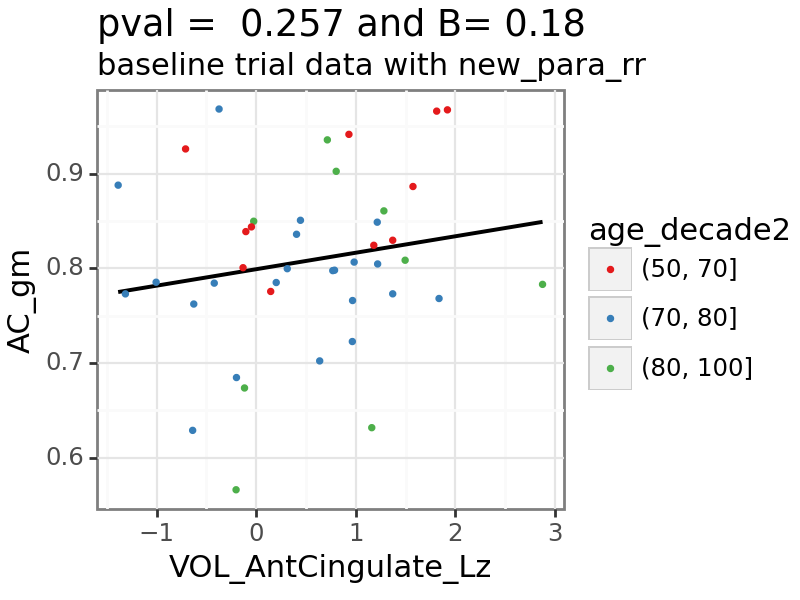

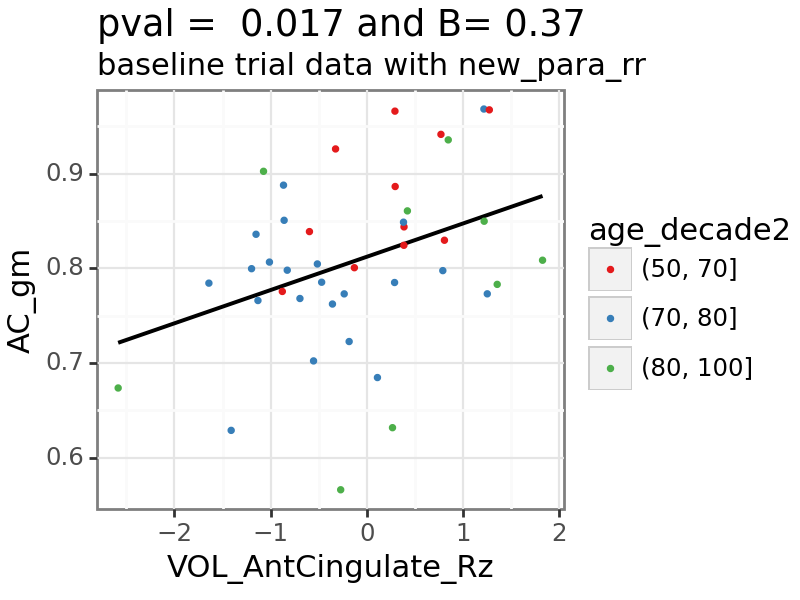

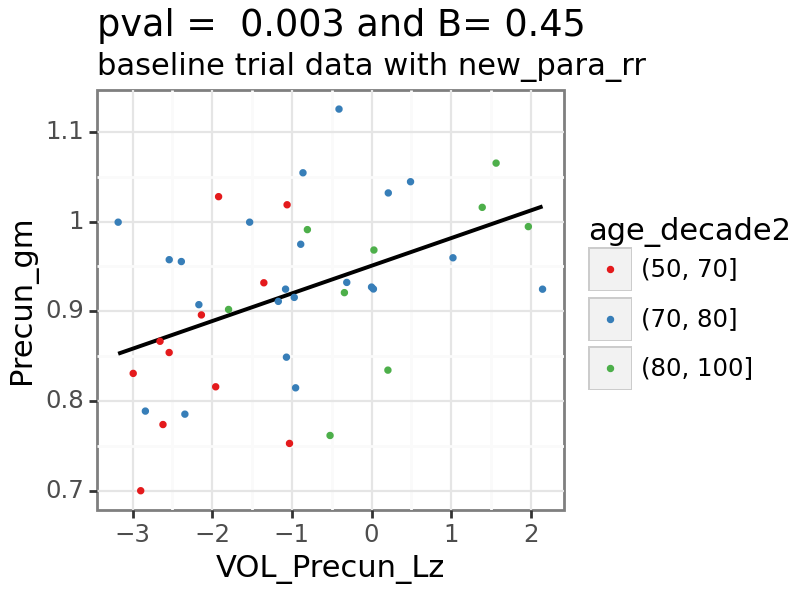

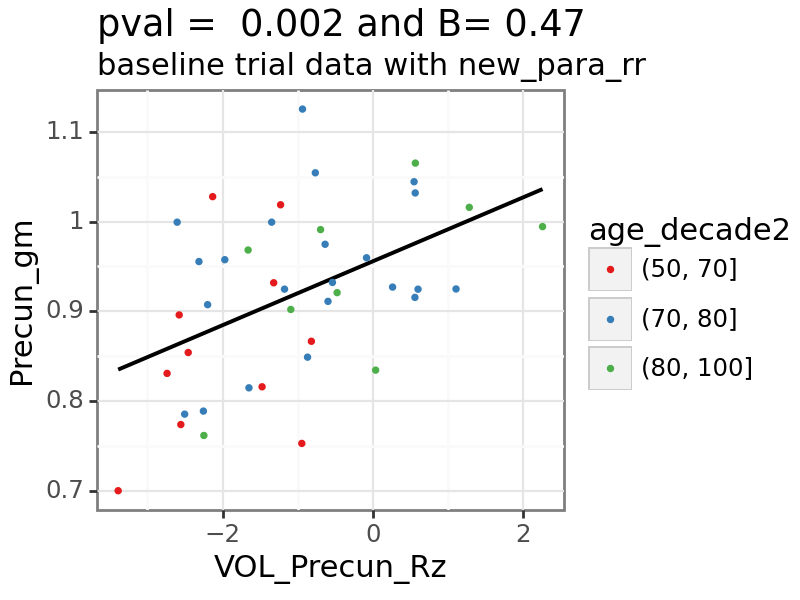

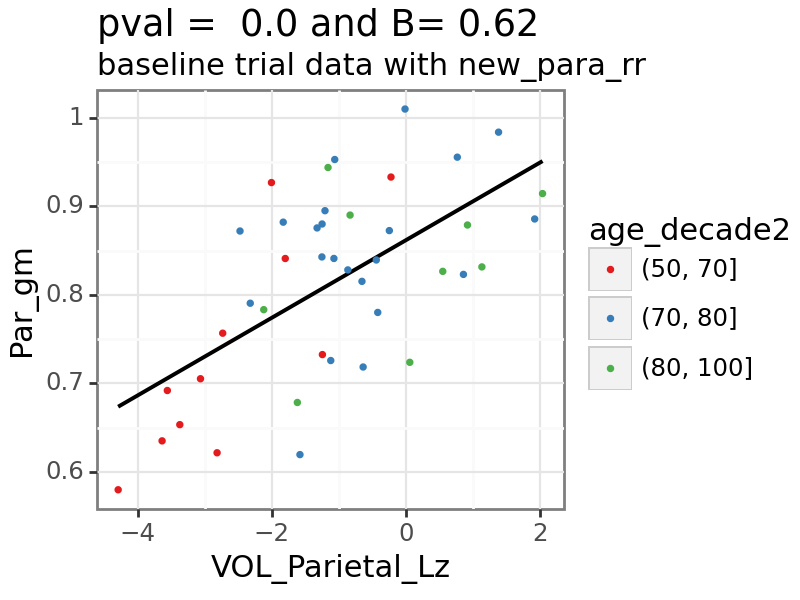

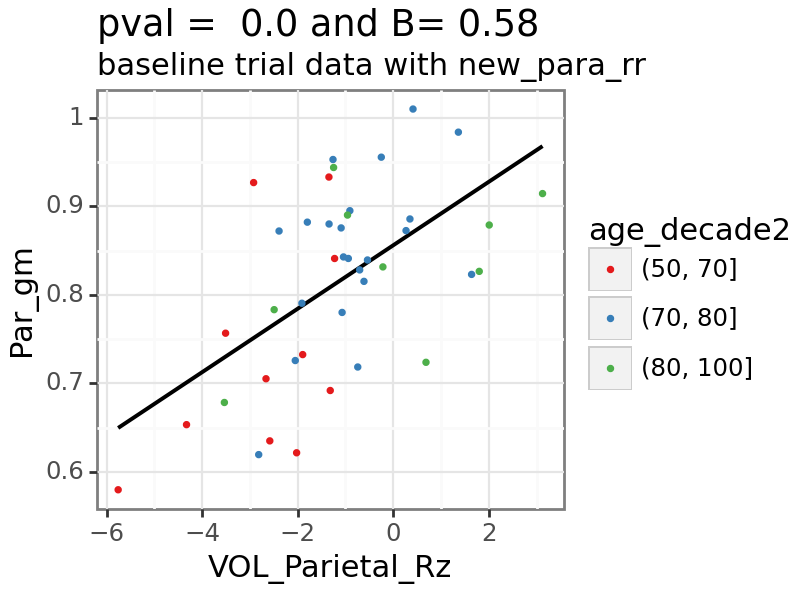

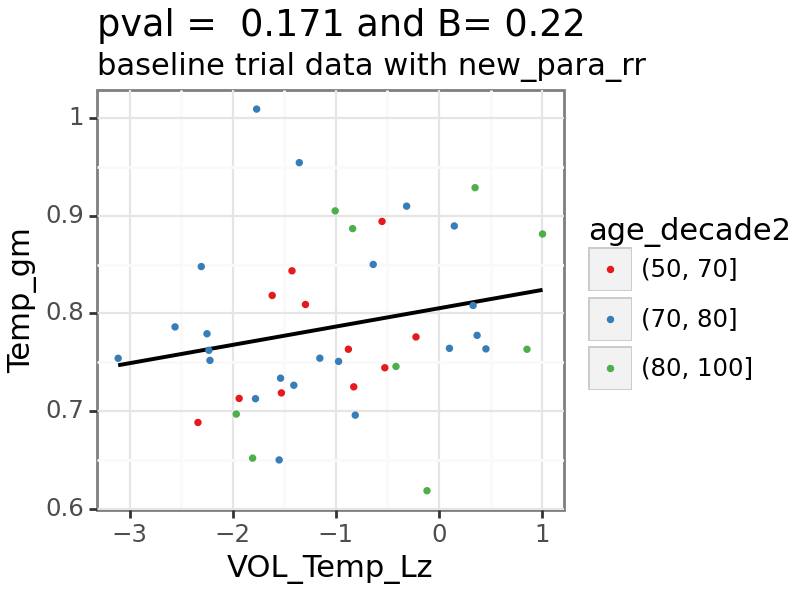

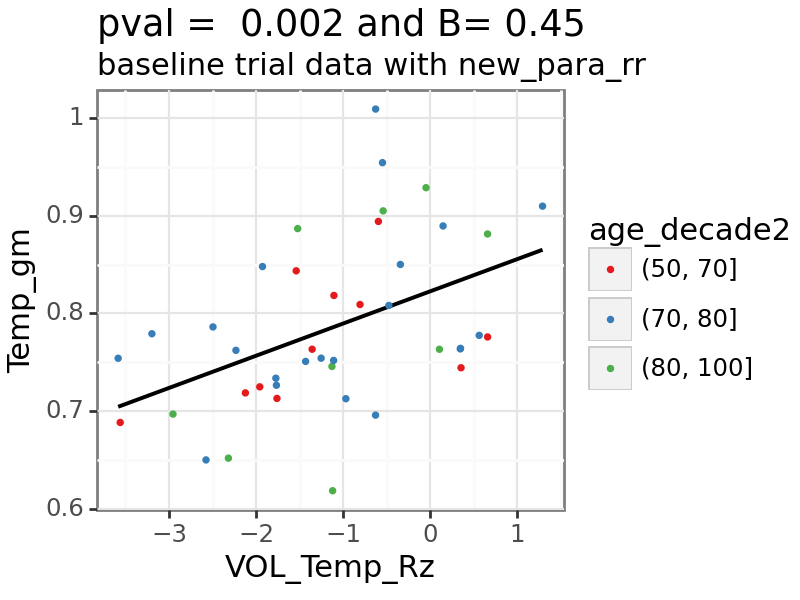

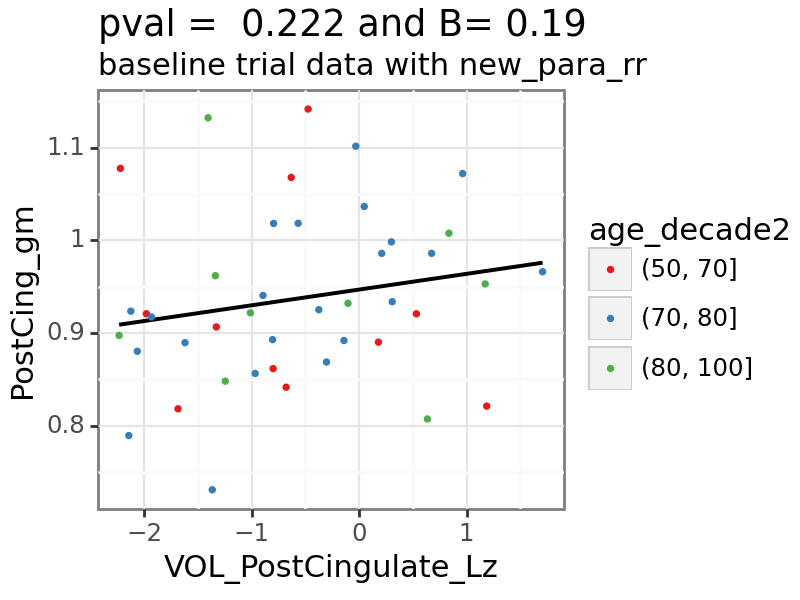

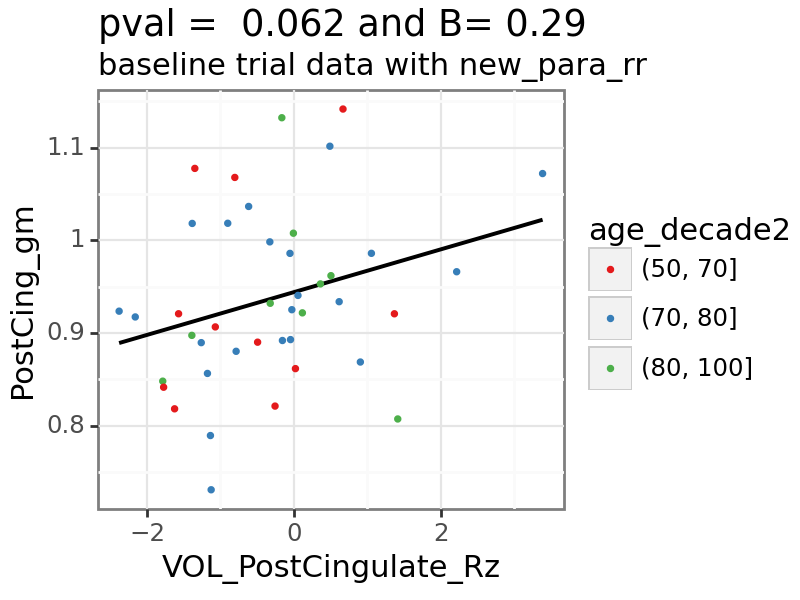

In [33]:
p9.options.figure_size = (4,3)    
for idx in biomarker_relationship_results_log10.index:
    x_var = biomarker_relationship_results_log10.iloc[idx]['x_var']
    y_var = biomarker_relationship_results_log10.iloc[idx]['y_var']
    p_value = biomarker_relationship_results_log10.loc[biomarker_relationship_results_log10['y_var'].isin([y_var]) & biomarker_relationship_results_log10['x_var'].isin([x_var]), selected_p_column[0]].reset_index(drop=True)[0].round(3).astype('str')
    B_value = biomarker_relationship_results_log10.loc[biomarker_relationship_results_log10['y_var'].isin([y_var]) & biomarker_relationship_results_log10['x_var'].isin([x_var]), 'model_B_val_x_var'].reset_index(drop=True)[0].round(2).astype('str')

    
    subset_data = baseline_trial_data.dropna(subset = [y_var, x_var])
    subset_data2 = subset_data.copy()
    subset_data2 = subset_data2.groupby('age_decade2', observed=True).filter(lambda x: x['ID_ADM'].nunique()> 10)
    plot = (
            p9.ggplot(subset_data, p9.aes(x = y_var, y = x_var, color = 'age_decade2'))
            + p9.theme_bw(base_size = 11)
            + p9.geom_smooth(subset_data, size = 0.8, se = False, alpha = 1, color = 'black', method = 'lm')
            #+ p9.geom_smooth(subset_data2, size = 0.8, se = False, alpha = 1)
            
            + p9.geom_point(size = 0.5)
            + p9.labs(title = ('pval =  ' + p_value + ' and B= ' + B_value), subtitle = 'baseline trial data with ' + data_name)
            + p9.scale_color_brewer(type='qual', palette='Set1')
        )
    print(plot)